In [16]:
import torch
from torch import nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision.io import read_image
from torchvision import models, datasets, transforms
from torchvision.models import vgg16, VGG16_Weights
from torchvision.transforms import ToTensor, Lambda
from torch.utils.data import Dataset, DataLoader
import os
import imageio
import numpy as np
import pandas as pd
import PIL.Image as pil
import matplotlib.pyplot as plt

In [17]:
def color2class(img):
    img = np.transpose(img, (1, 2, 0)).numpy()
    color = (img>=128).astype(np.uint8)
    color = 4*color[:,:,0]+2*color[:,:,1]+color[:,:,2]
    classs = np.empty((512, 512))
    classs[color==3] = 0  # (Cyan: 011) Urban land 
    classs[color==6] = 1  # (Yellow: 110) Agriculture land 
    classs[color==5] = 2  # (Purple: 101) Rangeland 
    classs[color==2] = 3  # (Green: 010) Forest land 
    classs[color==1] = 4  # (Blue: 001) Water 
    classs[color==7] = 5  # (White: 111) Barren land 
    classs[color==0] = 6  # (Black: 000) Unknown
    classs = torch.tensor(classs)
    return classs

def class2label(img):
    label = F.one_hot(img.to(torch.long), num_classes=7)
    label = np.transpose(label, (2, 0, 1))
    return label

def label2class(img):
    return torch.argmax(img, 0)

def class2color(classs):
    color = np.array([[0,255,255], [255,255,0], [255,0,255], [0,255,0], [0,0,255], [255,255,255], [0,0,0]])
    colorimg = np.empty((512,512,3))
    for i in range(7):
        colorimg[classs==i] = color[i]
    colorimg = torch.tensor(np.transpose(colorimg, (2, 0, 1)))
    return colorimg

In [18]:
img_path = 'hw1_data/p2_data/validation/'
temp_path = 'hw1_data/p2_data/pred_temp/'
pred_path = 'hw1_data/p2_data/val_pred/'
evolution_dir = 'hw1_data/p2_data/evolution/'
evolution_save = ['0013_mask.png','0062_mask.png','0104_mask.png','0008_mask.png','0010_mask.png',
                  '0021_mask.png','0058_mask.png','0077_mask.png','0102_mask.png','0107_mask.png',
                  '0131_mask.png','0140_mask.png','0177_mask.png','0195_mask.png','0239_mask.png']

def read_masks(filepath):
    file_list = [file for file in os.listdir(filepath) if file.endswith('.png')]
    file_list.sort()
    n_masks = len(file_list)
    masks = np.empty((n_masks, 512, 512))
    for i, file in enumerate(file_list):
        mask = imageio.v2.imread(os.path.join(filepath, file))
        mask = (mask >= 128).astype(int)
        mask = 4 * mask[:, :, 0] + 2 * mask[:, :, 1] + mask[:, :, 2]
        masks[i, mask == 3] = 0  # (Cyan: 011) Urban land 
        masks[i, mask == 6] = 1  # (Yellow: 110) Agriculture land 
        masks[i, mask == 5] = 2  # (Purple: 101) Rangeland 
        masks[i, mask == 2] = 3  # (Green: 010) Forest land 
        masks[i, mask == 1] = 4  # (Blue: 001) Water 
        masks[i, mask == 7] = 5  # (White: 111) Barren land 
        masks[i, mask == 0] = 6  # (Black: 000) Unknown 
    return masks

def mean_iou_score(pred, labels):
    mean_iou = 0
    for i in range(6):
        tp_fp = np.sum(pred == i)
        tp_fn = np.sum(labels == i)
        tp = np.sum((pred == i) * (labels == i))
        iou = tp / (tp_fp + tp_fn - tp)
        mean_iou += iou / 6
        print('class #%d : %1.5f'%(i, iou))
    print('\nmean_iou: %f\n' % mean_iou)
    return mean_iou

def seg_pred(ee, model, input_dir, output_dir, transform=None):
    t = transforms.Compose([transforms.ToTensor(),
                            transforms.ConvertImageDtype(torch.uint8)])
    img_list = [file for file in os.listdir(input_dir) if file.endswith('.jpg')]
    img_list.sort()
    mask_list = [file for file in os.listdir(input_dir) if file.endswith('.png')]
    mask_list.sort()
    for i, f in enumerate(img_list):
        img = imageio.v2.imread(f'{img_path}/{f}')
        img = t(img)
        if transform:
            img = transform(img)
        img = torch.unsqueeze(img.to(torch.float), 0)
        img = img.to(device)
        pred_lebel = model(img)
        pred_class = torch.squeeze(pred_lebel.argmax(1), 0)
        pred_color = class2color(pred_class.to('cpu'))
        pred_mask = np.transpose(pred_color.to(torch.uint8), (1, 2, 0))
        save_path = f'{output_dir}{mask_list[i]}'
        imageio.imsave(save_path, pred_mask)
        if mask_list[i] in evolution_save:
            save_path2 = f'{evolution_dir}{ee}_{mask_list[i]}'
            imageio.imsave(save_path2, pred_mask)
    preds = read_masks(output_dir)
    labels = read_masks(input_dir)
    mean_iou = mean_iou_score(preds, labels)
    return mean_iou

In [19]:
class ImageDataset(Dataset):
    def __init__(self, data_dir, transform=None, target_transform=None):
        self.data_dir = data_dir
        self.transform=transform
        self.target_transform=target_transform
        self.seed = 0

    def __len__(self):
        img_list = [file for file in os.listdir(self.data_dir) if file.endswith('.jpg')]
        return len(img_list)

    def __getitem__(self, idx):
        idx = str(idx).zfill(4)
        img_path = os.path.join(self.data_dir, f'{idx}_sat.jpg')
        image = read_image(img_path)
        color = os.path.join(self.data_dir, f'{idx}_mask.png')
        color = read_image(color)
        seed = np.random.randint(1,9999)
        image = image.to(torch.uint8)
        if self.transform:
            torch.manual_seed(seed)
#             print(self.seed)
            image = self.transform(image)
        if self.target_transform:
            torch.manual_seed(seed)
#             print(self.seed)
            color = self.target_transform(color)
        classs = color2class(color)
        label = class2label(classs).to(torch.float)
        image = image.to(torch.float)
        return image, color, classs, label

In [20]:
train_data_dir = 'hw1_data/p2_data/train/'
test_data_dir = 'hw1_data/p2_data/validation/'

In [21]:
train_transform = transforms.Compose([transforms.RandomHorizontalFlip(p=0.5),
                                      transforms.RandomVerticalFlip(p=0.5),
                                      transforms.RandomResizedCrop((512, 512), scale=(0.2, 1)),
                                      transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0)])

train_target_transform = transforms.Compose([transforms.RandomHorizontalFlip(p=0.5),
                                             transforms.RandomVerticalFlip(p=0.5),
                                             transforms.RandomResizedCrop((512, 512), scale=(0.2, 1))])
test_transform = None
# test_transform = transforms.ColorJitter(brightness=0, contrast=(1.5,1.5), saturation=(1.5,1.5), hue=0)
test_target_transform = None
batch_size = 4

In [22]:
train_data = ImageDataset(data_dir=train_data_dir, transform=train_transform, target_transform=train_target_transform)
test_data = ImageDataset(data_dir=test_data_dir, transform=test_transform, target_transform=test_target_transform)

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

In [23]:
image, color, classs, label  = next(iter(train_dataloader))
print(f"Feature batch shape: {image.size()}")
print(f"Labels batch shape: {label.size()}")

Feature batch shape: torch.Size([4, 3, 512, 512])
Labels batch shape: torch.Size([4, 7, 512, 512])


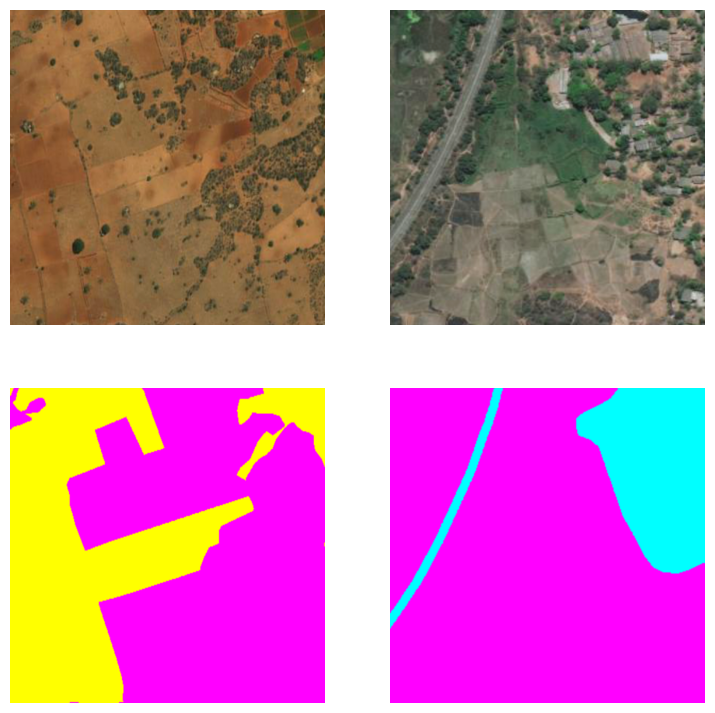

In [24]:
figure = plt.figure(figsize=(9, 9))
rows, cols = 2, 2
for i in range(1, cols+1):
    sample_idx = i+200
    image, color, classs, label = train_data[sample_idx]
    image = np.transpose(image.to(torch.uint8), (1, 2, 0))
    figure.add_subplot(rows, cols, i)
    plt.imshow(image.squeeze())
    plt.axis("off")
    color = np.transpose(color.to(torch.uint8), (1, 2, 0))
    figure.add_subplot(rows, cols, i+cols)
    plt.imshow(color.squeeze())
    plt.axis("off")
plt.show()

In [26]:
class en_de(nn.Module):
    def __init__(self):
        super(en_de, self).__init__()
        self.encoder = vgg16(weights=VGG16_Weights.IMAGENET1K_V1).features[:31]
        self.decoder = nn.Sequential(nn.Conv2d(512, 512, 3, padding='same'), nn.ReLU(),
                                     nn.Conv2d(512, 256, 3, padding='same'), nn.ReLU(),
                                     nn.Upsample(scale_factor=2, mode='bilinear'),
                                     nn.Conv2d(256, 256, 3, padding='same'), nn.ReLU(),
                                     nn.Conv2d(256, 256, 3, padding='same'), nn.ReLU(),
                                     nn.Upsample(scale_factor=2, mode='bilinear'),
                                     nn.Conv2d(256, 256, 3, padding='same'), nn.ReLU(),
                                     nn.Conv2d(256, 128, 3, padding='same'), nn.ReLU(),
                                     nn.Upsample(scale_factor=2, mode='bilinear'),
                                     nn.Conv2d(128, 128, 3, padding='same'), nn.ReLU(),
                                     nn.Conv2d(128, 128, 3, padding='same'), nn.ReLU(),
                                     nn.Upsample(scale_factor=2, mode='bilinear'),
                                     nn.Conv2d(128, 128, 3, padding='same'), nn.ReLU(),
                                     nn.Conv2d(128, 64, 3, padding='same'), nn.ReLU(),
                                     nn.Upsample(scale_factor=2, mode='bilinear'),
                                     nn.Conv2d(64, 64, 3, padding='same'), nn.ReLU(),
                                     nn.Conv2d(64, 7, 3, padding='same'))
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
model_ende = en_de()
model_ende

en_de(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=

In [28]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
# model_ende = torch.load('ende/model_ende_325.pth')
# model_ende.to(device)

best_model_ende = en_de()
best_acc = 0.0
# best_acc = 0.7315
# best_model_ende = torch.load('best_model_ende.pth')

record = {'train_loss':[], 'train_acc':[],'test_loss':[], 'test_acc':[], 'test_miou':[]}
# record_load = np.load('ende/record.npz')
# record['train_loss'] = record_load['train_loss'].tolist()
# record['train_acc'] = record_load['train_acc'].tolist()
# record['test_loss'] = record_load['test_loss'].tolist()
# record['test_acc'] = record_load['test_acc'].tolist()
# record['test_miou'] = record_load['test_miou'].tolist()

cuda:0


In [29]:
def train_loop(dataloader, model, loss_fn, optimizer, scheduler=None):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    step = int(num_batches/10)
    train_loss, train_acc = 0, 0
    for batch, (X, _, c, y) in enumerate(dataloader):
        X, y, c = X.float(), y.float(), c.float()
        X, y, c = X.to(device), y.to(device), c.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)
        train_loss += loss.item()
        batch_acc = (pred.argmax(1)==y.argmax(1)).type(torch.float).sum().item()
        train_acc += batch_acc
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch % step == 0:
            loss, current = loss.item(), (batch+1)*len(X)
            print(f"loss: {loss:>7f}, acc: {(100*batch_acc/(batch_size*512*512)):>0.1f}%  [{current:>5d}/{size:>5d}]")
    if scheduler is not None:
        scheduler.step()
    train_loss /= num_batches
    train_acc /= (size*512*512)
    print(f"Train | Avg_loss: {train_loss:>8f}, Accuracy: {(100*train_acc):>0.1f}%")
    return train_loss, train_acc

def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, test_acc = 0, 0
    with torch.no_grad():
        for X, _, c, y in dataloader:
            X, y, c = X.float(), y.float(), c.float()
            X, y, c = X.to(device), y.to(device), c.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            test_acc += (pred.argmax(1)==y.argmax(1)).type(torch.float).sum().item()
    test_loss /= num_batches
    test_acc /= (size*512*512)
    print(f"Test  | Avg_loss: {test_loss:>8f}, Accuracy: {(100*test_acc):>0.1f}%\n")
    return test_loss, test_acc

In [30]:
learning_rate = 5e-5
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_ende.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

In [34]:
img_path = 'hw1_data/p2_data/validation/'
temp_path = 'hw1_data/p2_data/pred_temp/'
pred_path = 'hw1_data/p2_data/val_pred/'
epochs = 100
for e in range(1, epochs+1):
    ee = len(record['train_loss'])+1
    print(f"Epoch {ee}\n------------------------------------------")
    train_loss, train_acc = train_loop(train_dataloader, model_ende, loss_fn, optimizer, scheduler)
    test_loss, test_acc = test_loop(test_dataloader, model_ende, loss_fn)
    record['train_loss'].append(train_loss)
    record['train_acc'].append(train_acc)
    record['test_loss'].append(test_loss)
    record['test_acc'].append(test_acc)
    test_miou = seg_pred(str(ee), model_ende, img_path, temp_path)
    record['test_miou'].append(test_miou)
    if test_miou > best_acc:
        best_acc = test_miou
        best_model_ende.load_state_dict(model_ende.state_dict())
    if (ee%25 == 0) or (ee == 1):
        torch.save(model_ende, f'model_ende_{ee}.pth')
        torch.save(best_model_ende, f'best_model_ende.pth')
        np.savez(f'record', train_loss=np.array(record['train_loss']), train_acc=np.array(record['train_acc']),
                 test_loss=np.array(record['test_loss']), test_acc=np.array(record['test_acc']), test_miou=np.array(record['test_miou']))
    
print("Done!")

Epoch 326
------------------------------------------
loss: 0.119056, acc: 95.5%  [    4/ 2000]
loss: 0.209847, acc: 93.6%  [  204/ 2000]
loss: 0.090140, acc: 97.1%  [  404/ 2000]
loss: 0.113308, acc: 95.1%  [  604/ 2000]
loss: 0.217104, acc: 92.0%  [  804/ 2000]
loss: 0.144318, acc: 95.1%  [ 1004/ 2000]
loss: 0.470972, acc: 81.0%  [ 1204/ 2000]
loss: 0.233097, acc: 90.6%  [ 1404/ 2000]
loss: 0.194342, acc: 93.2%  [ 1604/ 2000]
loss: 0.103352, acc: 96.3%  [ 1804/ 2000]
Train | Avg_loss: 0.166810, Accuracy: 94.2%
Test  | Avg_loss: 0.428528, Accuracy: 86.6%

class #0 : 0.74069
class #1 : 0.85923
class #2 : 0.36223
class #3 : 0.76689
class #4 : 0.77581
class #5 : 0.68284

mean_iou: 0.697947

Epoch 327
------------------------------------------
loss: 0.197415, acc: 93.8%  [    4/ 2000]
loss: 0.113914, acc: 94.9%  [  204/ 2000]
loss: 0.114306, acc: 96.1%  [  404/ 2000]
loss: 0.140871, acc: 95.4%  [  604/ 2000]
loss: 0.111328, acc: 97.3%  [  804/ 2000]
loss: 0.096388, acc: 96.0%  [ 1004/ 2000

class #0 : 0.75388
class #1 : 0.89126
class #2 : 0.37516
class #3 : 0.78410
class #4 : 0.76977
class #5 : 0.69907

mean_iou: 0.712207

Epoch 338
------------------------------------------
loss: 0.027708, acc: 99.3%  [    4/ 2000]
loss: 0.090168, acc: 96.4%  [  204/ 2000]
loss: 0.053962, acc: 97.8%  [  404/ 2000]
loss: 0.047880, acc: 98.4%  [  604/ 2000]
loss: 0.033166, acc: 98.9%  [  804/ 2000]
loss: 0.099923, acc: 96.5%  [ 1004/ 2000]
loss: 0.084025, acc: 96.8%  [ 1204/ 2000]
loss: 0.078489, acc: 97.3%  [ 1404/ 2000]
loss: 0.124414, acc: 95.8%  [ 1604/ 2000]
loss: 0.392191, acc: 85.4%  [ 1804/ 2000]
Train | Avg_loss: 0.122048, Accuracy: 95.5%
Test  | Avg_loss: 0.429825, Accuracy: 89.1%

class #0 : 0.75538
class #1 : 0.89258
class #2 : 0.35952
class #3 : 0.80959
class #4 : 0.78138
class #5 : 0.71819

mean_iou: 0.719440

Epoch 339
------------------------------------------
loss: 0.106618, acc: 96.4%  [    4/ 2000]
loss: 0.254753, acc: 91.0%  [  204/ 2000]
loss: 0.064229, acc: 98.1%  [  

loss: 0.084227, acc: 96.9%  [ 1804/ 2000]
Train | Avg_loss: 0.105674, Accuracy: 96.1%
Test  | Avg_loss: 0.407237, Accuracy: 89.4%

class #0 : 0.75508
class #1 : 0.89329
class #2 : 0.39928
class #3 : 0.80519
class #4 : 0.77659
class #5 : 0.72503

mean_iou: 0.725742

Epoch 350
------------------------------------------
loss: 0.017188, acc: 99.3%  [    4/ 2000]
loss: 0.085231, acc: 96.7%  [  204/ 2000]
loss: 0.119228, acc: 95.9%  [  404/ 2000]
loss: 0.057592, acc: 97.8%  [  604/ 2000]
loss: 0.154169, acc: 93.8%  [  804/ 2000]
loss: 0.143720, acc: 94.2%  [ 1004/ 2000]
loss: 0.087415, acc: 96.6%  [ 1204/ 2000]
loss: 0.128760, acc: 95.4%  [ 1404/ 2000]
loss: 0.244039, acc: 90.0%  [ 1604/ 2000]
loss: 0.078185, acc: 97.8%  [ 1804/ 2000]
Train | Avg_loss: 0.105761, Accuracy: 96.1%
Test  | Avg_loss: 0.388023, Accuracy: 89.3%

class #0 : 0.75800
class #1 : 0.89348
class #2 : 0.39256
class #3 : 0.80974
class #4 : 0.77799
class #5 : 0.72134

mean_iou: 0.725517

Epoch 351
---------------------------

loss: 0.136092, acc: 94.1%  [ 1004/ 2000]
loss: 0.134970, acc: 95.5%  [ 1204/ 2000]
loss: 0.041406, acc: 98.5%  [ 1404/ 2000]
loss: 0.044019, acc: 98.3%  [ 1604/ 2000]
loss: 0.079656, acc: 96.8%  [ 1804/ 2000]
Train | Avg_loss: 0.094292, Accuracy: 96.4%
Test  | Avg_loss: 0.416829, Accuracy: 89.5%

class #0 : 0.75923
class #1 : 0.89594
class #2 : 0.39668
class #3 : 0.81884
class #4 : 0.77978
class #5 : 0.72511

mean_iou: 0.729263

Epoch 362
------------------------------------------
loss: 0.030399, acc: 99.0%  [    4/ 2000]
loss: 0.107465, acc: 94.8%  [  204/ 2000]
loss: 0.087590, acc: 96.4%  [  404/ 2000]
loss: 0.092132, acc: 95.9%  [  604/ 2000]
loss: 0.126634, acc: 94.6%  [  804/ 2000]
loss: 0.050310, acc: 98.2%  [ 1004/ 2000]
loss: 0.113704, acc: 95.5%  [ 1204/ 2000]
loss: 0.172820, acc: 93.3%  [ 1404/ 2000]
loss: 0.058459, acc: 97.9%  [ 1604/ 2000]
loss: 0.165009, acc: 93.6%  [ 1804/ 2000]
Train | Avg_loss: 0.093966, Accuracy: 96.5%
Test  | Avg_loss: 0.439649, Accuracy: 89.3%

clas

KeyboardInterrupt: 

In [ ]:
# 0（青色：011）城市土地
# 1（黃色：110）農業用地
# 2（紫色：101）牧場
# 3（綠色：010）林地
# 4（藍色：001）水
# 5（白色：111）荒地
# 6（黑色：000）未知

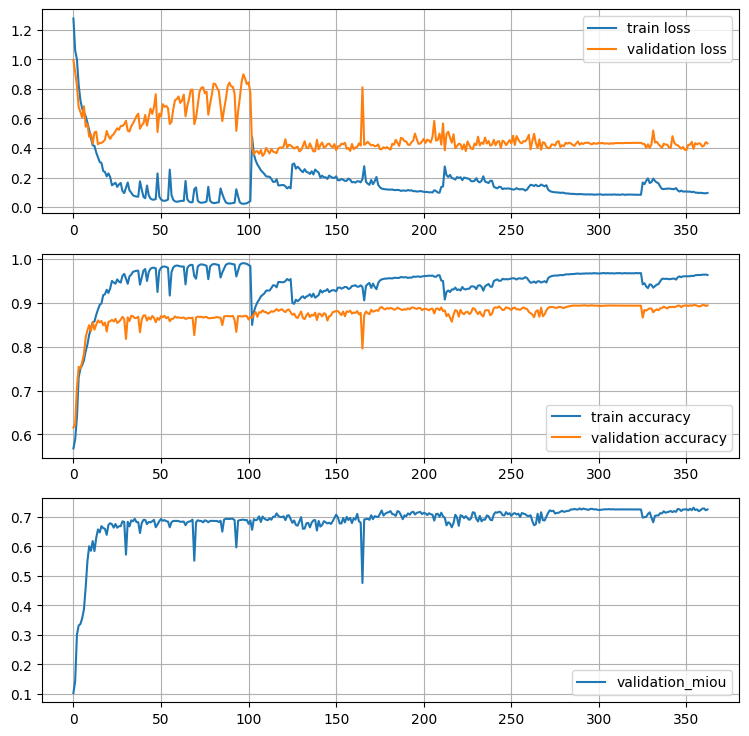

In [35]:
plt.figure(figsize=(9, 9))
plt.grid()
plt.subplot(311)
plt.plot(np.arange(len(record['train_loss'])), record['train_loss'], np.arange(len(record['test_loss'])), record['test_loss'])
plt.legend(['train loss', 'validation loss'])
plt.grid()
plt.subplot(312)
plt.plot(np.arange(len(record['train_acc'])), record['train_acc'], np.arange(len(record['test_acc'])), record['test_acc'])
plt.legend(['train accuracy', 'validation accuracy'])
plt.grid()
plt.subplot(313)
plt.plot(np.arange(len(record['test_miou'])), record['test_miou'])
plt.legend(['validation_miou', 'validation accuracy'])
plt.grid()
plt.show()

In [36]:
max(record['test_miou'])

0.7315054386220633

In [39]:
torch.save(model_ende, 'model_ende.pth')
torch.save(best_model_ende, 'best_model_ende.pth')
np.savez(f'record', train_loss=np.array(record['train_loss']), train_acc=np.array(record['train_acc']),
           test_loss=np.array(record['test_loss']), test_acc=np.array(record['test_acc']), test_miou=np.array(record['test_miou']))

In [31]:
seg_pred('test', best_model_ende.to(device), img_path, temp_path)

class #0 : 0.75721
class #1 : 0.89413
class #2 : 0.39875
class #3 : 0.82904
class #4 : 0.78274
class #5 : 0.72716

mean_iou: 0.731505



0.7315054386220633